In [14]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from Utility.load_data import load_processed_data, show_random_images, write_images_from_dict
from Utility.calculations import *
from Utility.preprocessing import perform_grayscale


## Load Data


In [7]:
data = load_processed_data('../resized')

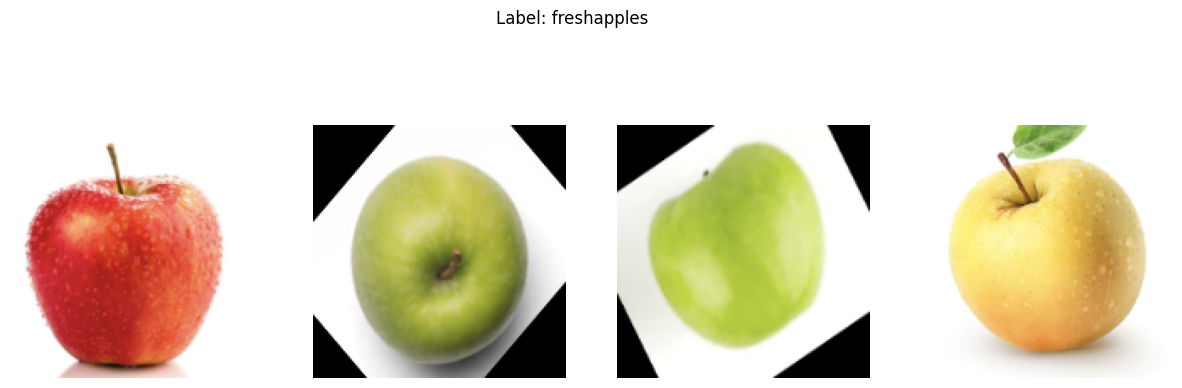

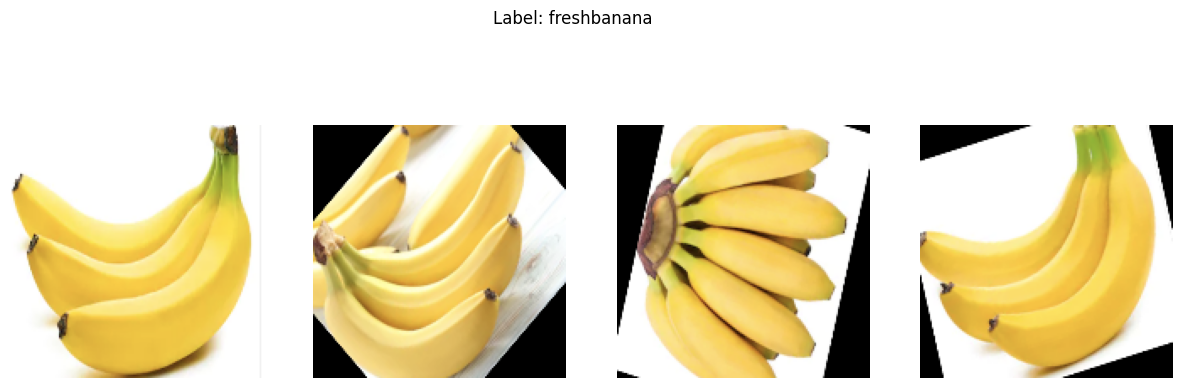

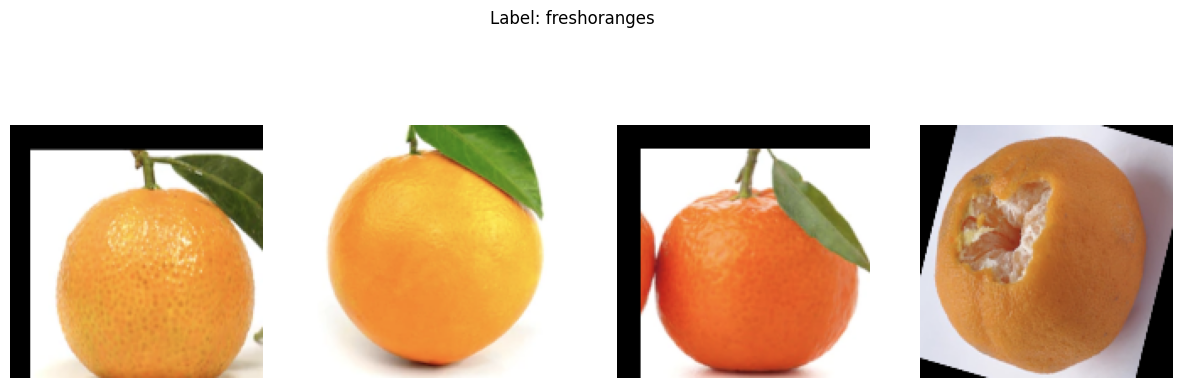

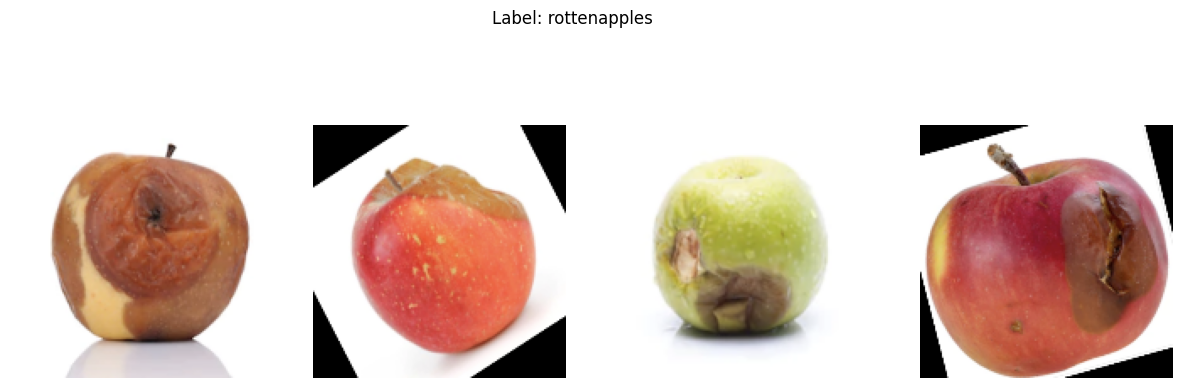

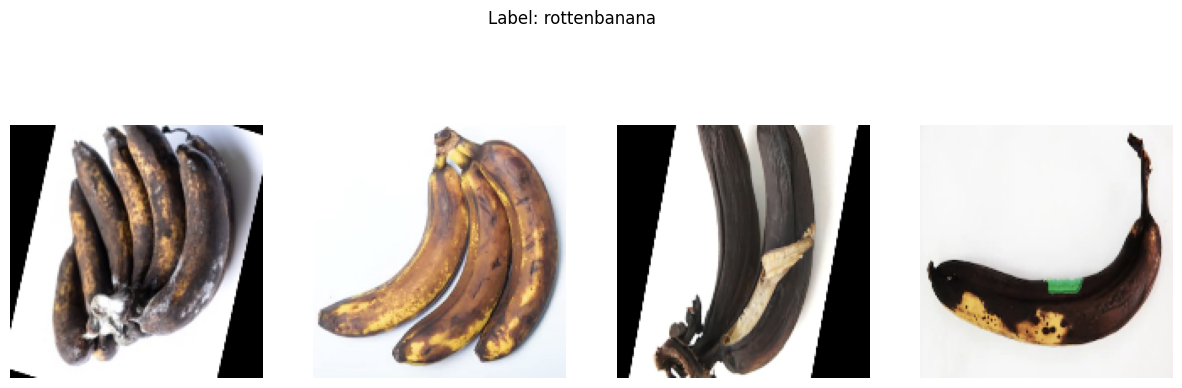

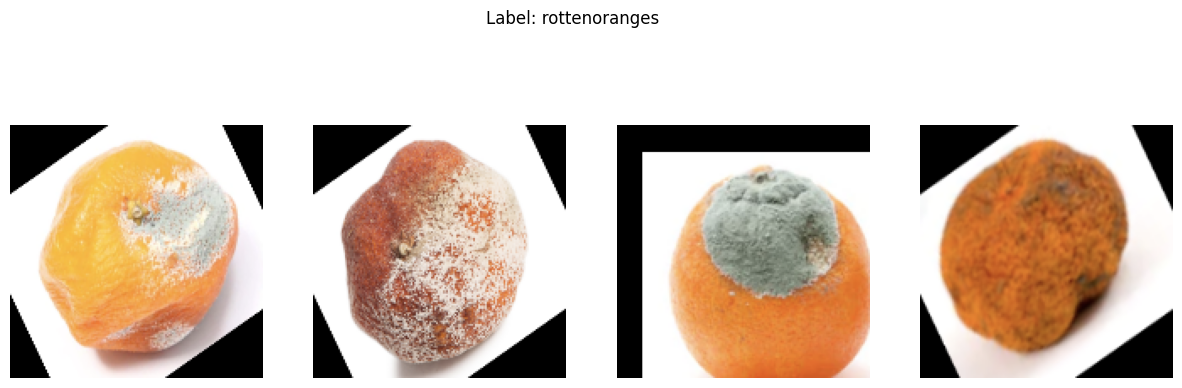

In [3]:
for label in data.keys():
    show_random_images(data, label, 4)

## Preprocessing


In [8]:
grayscaled = perform_grayscale(data)

In [5]:
# Edge Detection using prewitt method
def edge_detection(image):
    # blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)
    result = cv2.Canny(image, 20, 200)
    return result

In [6]:
def edge_detection_sobel(image):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]])

    edge_x = cv2.filter2D(image, cv2.CV_64F, sobel_x)
    edge_y = cv2.filter2D(image, cv2.CV_64F, sobel_y)

    edge_magnitude = np.sqrt(edge_x ** 2 + edge_y ** 2)
    edge_magnitude = np.uint8(edge_magnitude)    

    return edge_magnitude

In [7]:
def median(image, baris, kolom):
    tengah = int(baris*kolom/2)
    hasil = np.zeros(image.shape).astype(np.uint8)
    _baris = int((baris-1)/2)
    _kolom = int((kolom-1)/2)
    _image = np.pad(image, ((_baris, _baris), (_kolom, _kolom)), mode='edge')
    for i in range(hasil.shape[0]):
        for j in range(hasil.shape[1]):
            Median = np.zeros(baris*kolom)
            m = 0
            for k in range(i, i+baris):
                for l in range(j, j+kolom):
                    Median[m] = _image[k, l]
                    m += 1
            Median.sort()
            a = Median[tengah]
            b = Median[tengah-1]
            _Median = int(a+b)/2
            hasil[i, j] = _Median
    return hasil

In [8]:
def thresholding(image):
    thresh, binary = cv2.threshold(image, 60, 255, cv2.THRESH_BINARY)
    return binary

In [9]:
def dilation(image, kernel=np.ones((3, 3), np.uint8)):
    return cv2.dilate(image, kernel, iterations=1)

In [10]:
def skeletonize(image, element):
    size = np.size(image)
    skel = np.zeros(image.shape).astype(np.uint8)
    
    if len(image.shape) != 2:
        raise ValueError("Input image must be a binary image with 8-bit single channel.")

    # element = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))
    done = False

    while not done:
        eroded = cv2.erode(image, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(image, temp)
        skel = cv2.bitwise_or(skel, temp)
        image = eroded.copy()
        
        zeros = size - cv2.countNonZero(image)
        if zeros == size:
            done = True
        
    return skel

In [11]:
kernelSmooth = np.array([[1/10, 1/10, 1/10],
                         [1/10, 1/5, 1/10],
                         [1/10, 1/10, 1/10]])
structuring_element = np.array([[0, 0, 1, 0, 0],
                                [0, 1, 1, 1, 0],
                                [1, 1, 1, 1, 1],
                                [0, 1, 1, 1, 0],
                                [0, 0, 1, 0, 0]], dtype=np.uint8)

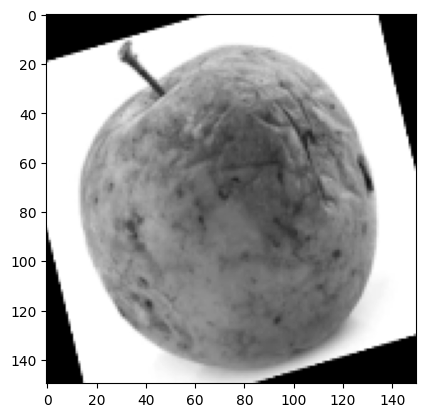

In [12]:
tes_image = grayscaled['rottenapples'][1]

plt.imshow(tes_image, cmap='gray')

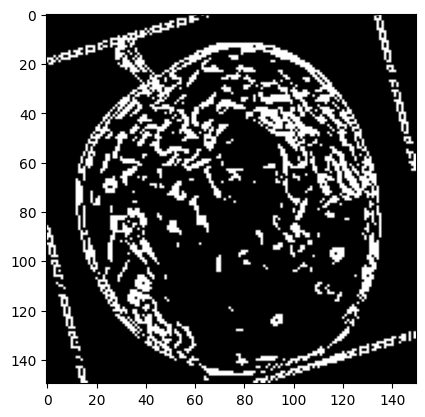

In [13]:
medianed = median(tes_image, 3, 3)
sobel_median = edge_detection_sobel(medianed)
thresholded = thresholding(sobel_median)

# dilated = dilation(thresholded)
skeleton = skeletonize(thresholded, structuring_element)
plt.imshow(skeleton, cmap='gray')

In [14]:
def perform_median(images:dict):
    result = images
    for label in images.keys():
        for i in range(len(images[label])):
            result[label][i] = median(result[label][i], 3, 3)
    return result
def perform_sobel(images:dict):
    result = images
    for label in images.keys():
        for i in range(len(images[label])):
            result[label][i] = edge_detection_sobel(result[label][i])
    return result
def perform_thresholding(images:dict):
    result = images
    for label in images.keys():
        for i in range(len(images[label])):
            result[label][i] = thresholding(result[label][i])
    return result
def perform_skeletonize(images:dict):
    result = images
    for label in images.keys():
        for i in range(len(images[label])):
            result[label][i] = skeletonize(result[label][i], structuring_element)
    return result

In [17]:
result = perform_median(grayscaled)
result = perform_sobel(result)
result = perform_thresholding(result)
result = perform_skeletonize(result)


In [18]:
write_images_from_dict(result, '../preprocessed/')

In [16]:
processed = load_processed_data('../preprocessed/')
processed = perform_grayscale(processed)

In [ ]:
for label in processed.keys():
    show_random_images(processed, label, 5)

In [26]:
from Utility.calculations import write_features_to_csv, perform_pca_feature_selection
from Utility.evaluations import *

In [21]:
dataframe_extracted_features = write_features_to_csv('../results/after_preprocessing', processed, [1], [0])

In [22]:
labels_list = dataframe_extracted_features['label'].tolist()

csv_dict = dataframe_extracted_features.drop(columns=['label']).to_dict('list')

In [32]:
prepared_data = pd.DataFrame(csv_dict).to_numpy()
reduced_data, pca_model = perform_pca_feature_selection(prepared_data, n_components=1)

Explained variance ratio: [0.90637557]


In [33]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

y = np.array(labels_list)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    reduced_data, y, test_size=0.2, random_state=42)

print('Jumlah training data:', len(X_train))
print('Jumlah testing data:', len(X_test))

Jumlah training data: 960
Jumlah testing data: 240


In [39]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf')  # Adjust kernel as needed
svm_model.fit(X_train, y_train)

SVC()

In [40]:
evaluate_model(svm_model, X_test, y_test)

Accuracy: 0.23333333333333334
Precision: 0.3288124745624746
Recall: 0.23333333333333334
